In [1]:
# to handle  data retrieval
import urllib3
from urllib3 import request
# to handle certificate verification
import certifi
# to manage json data
import json
from pprint import pprint
# to manage .grib format
import xarray as xr
import cfgrib
# to set up the directory
import os
from os import listdir
import glob
#for plotting
import matplotlib.pyplot as plt

In [2]:
http = urllib3.PoolManager(
       cert_reqs='CERT_REQUIRED',
       ca_certs=certifi.where())

In [3]:
#choose relevant parameters and insert your apikey for forecast data from DMI

model = 'wam_dw'
model_run= '2022-04-28T00:00:00Z'
api_key=''

In [4]:
url = f'https://dmigw.govcloud.dk/v1/forecastdata/collections/{model}/items?modelRun={model_run}&api-key={api_key}'
r = http.request('GET', url)
r.status

200

In [5]:
data = json.loads(r.data.decode())


In [6]:
#optional to inspect the content
#pprint(data, depth=1)

In [7]:
#pprint(data)

In [8]:
#setting up the directory for file download
dir = r'C:\Users\aageen17\Desktop\wave_model'
os.chdir(dir)

In [ ]:
# Get list of all URLs for download of .grib files from DMI's model run (around 100 files)

urls = [stac_item['asset']['data']['href'] for stac_item in data['features']]

# Download each URL
for url in urls:
    print(url)
    !wget --no-check-certificate {url}

In [10]:
#renaming the files
for filename in os.listdir(dir):
    os.rename(filename, filename.replace(f'@api-key={api_key}', ''))

In [11]:
# making a list of all downloaded netcdf files
netcdf_list = glob.glob(f'{dir}\*grib')

In [12]:
def preprocessing(ds): 
    return ds.expand_dims(dim='valid_time')

In [13]:
#merging the downloaded files into one
dsmerged = xr.open_mfdataset(
                      netcdf_list,
                      #compat='override',
                      combine = 'by_coords',
                      concat_dim ='valid_time',
                      engine="cfgrib",
                      preprocess = preprocessing)

In [14]:
#evt. choosing only relevant variables
dsmerged = dsmerged[['swh', 'mwd']]

In [15]:
dsmerged

<xarray.Dataset>
Dimensions:     (valid_time: 133, latitude: 701, longitude: 541)
Coordinates:
    time        datetime64[ns] 2022-04-28
    step        (valid_time) timedelta64[ns] 00:00:00 ... 5 days 12:00:00
    meanSea     float64 0.0
  * latitude    (latitude) float64 60.0 59.99 59.98 59.97 ... 53.02 53.01 53.0
  * longitude   (longitude) float64 7.0 7.017 7.033 7.05 ... 15.97 15.98 16.0
  * valid_time  (valid_time) datetime64[ns] 2022-04-28 ... 2022-05-03T12:00:00
Data variables:
    swh         (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 701, 541), meta=np.ndarray>
    mwd         (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 701, 541), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ekmi
    GRIB_centreDescription:  Copenhagen
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Copenhagen
    history:                 2022-04-29T11:44 GRIB to CDM+CF via cfgrib-0.9.1...

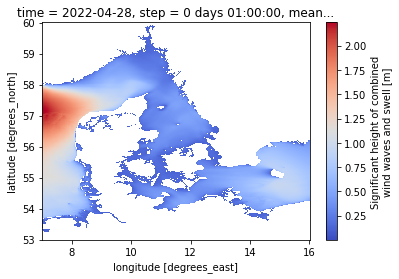

In [16]:
#visualisation
dsmerged.swh.isel(valid_time=1).plot(cmap=plt.cm.coolwarm)

In [17]:
#renaming and dropping unneccessary variables
dsmerged = (
    dsmerged.drop_vars(['time', 'step'])
    .rename_dims({'valid_time': 'time'})
    .rename_vars({'valid_time': 'time'})
)

In [18]:
#Saving as .netcdf that is ready to be opened and visualised i a GIS program
dsmerged.to_netcdf('waves_new.nc')

In [19]:
#deleting the original .grib files
ext = ('.grib', 'idx')
for file_name in listdir(dir):
    if file_name.endswith(ext):
        os.remove(os.path.join(dir, file_name))